In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F

In [2]:
colab = True
if colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)
  %cp "/content/drive/My Drive/autoencoder-training/data.zip" .
  !unzip -q data.zip
  image_path = "data"
else: 
  os.chdir("../")
  image_path = os.getcwd() + "/data"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data

In [0]:
np.random.seed(3333)
torch.manual_seed(3333)

size = 32
def get_data(size):
  batchsize = 128
  tfms = get_transforms(do_flip = True)
  src = (ImageImageList.from_folder(image_path).use_partial_data(0.1).split_by_folder().label_from_func(lambda x: x))
  data = (src.transform(tfms, size=size, tfm_y=True)
          .databunch(bs=batchsize)
          .normalize(imagenet_stats, do_y = False))
  return data

# Model

## Pixelshuffle

In [0]:
def icnr(x, scale=2, init=nn.init.kaiming_normal_):
    "ICNR init of `x`, with `scale` and `init` function."
    ni,nf,h,w = x.shape
    ni2 = int(ni/(scale**2))
    k = init(torch.zeros([ni2,nf,h,w])).transpose(0, 1)
    k = k.contiguous().view(ni2, nf, -1)
    k = k.repeat(1, 1, scale**2)
    k = k.contiguous().view([nf,ni,h,w]).transpose(0, 1)
    x.data.copy_(k)

class PixelShuffle_ICNR(nn.Module):
    "Upsample by `scale` from `ni` filters to `nf` (default `ni`), using `nn.PixelShuffle`, `icnr` init, and `weight_norm`."
    def __init__(self, ni:int, nf:int=None, scale:int=2, blur:bool=False, norm_type=NormType.Weight, leaky:float=None):
        super().__init__()
        nf = ifnone(nf, ni)
        self.conv = conv_layer(ni, nf*(scale**2), ks=1, norm_type=norm_type, use_activ=False)
        icnr(self.conv[0].weight)
        self.shuf = nn.PixelShuffle(scale)
        # Blurring over (h*w) kernel
        # "Super-Resolution using Convolutional Neural Networks without Any Checkerboard Artifacts"
        # - https://arxiv.org/abs/1806.02658
        self.pad = nn.ReplicationPad2d((1,0,1,0))
        self.blur = nn.AvgPool2d(2, stride=1)
        self.relu = relu(True, leaky=leaky)

    def forward(self,x):
        x = self.shuf(self.relu(self.conv(x)))
        return self.blur(self.pad(x)) if self.blur else x

## Autoencoder

In [0]:
class Encoder1(nn.Module):
    def __init__(self):
        super(Encoder1, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[0:3]))
        for param in resnet.parameters():
            param.requires_grad = False

        self.encoder = nn.Sequential(resnet)

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[3:5]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[1][i].bn1.parameters():
                param.requires_grad = True
            for param in resnet[1][i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class Encoder3(nn.Module):
    def __init__(self):
        super(Encoder3, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[5]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class Encoder4(nn.Module):
    def __init__(self):
        super(Encoder4, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[6]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class Encoder5(nn.Module):
    def __init__(self):
        super(Encoder5, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[7]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class AdaptiveConcatPool2d(Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz:Optional[int]=None):
        "Output will be 2*sz or 2 if sz is None"
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

class Encoder6(nn.Module):
    def __init__(self):
        super(Encoder6, self).__init__()

        self.encoder = nn.Sequential(AdaptiveConcatPool2d())

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class Decoder1(nn.Module):
    def __init__(self):
        super(Decoder1, self).__init__()

        self.decoder = nn.Sequential( 
            PixelShuffle_ICNR(64, 3),
            nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )

    def decode(self,x): return self.decoder(x)

    def forward(self, x):
      decoded = self.decoder(x)
      return decoded

class Decoder2(nn.Module):
    def __init__(self):
        super(Decoder2, self).__init__()

        self.decoder = nn.Sequential( 
            PixelShuffle_ICNR(64, 64),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def decode(self,x): return self.decoder(x)

    def forward(self, x):
      decoded = self.decoder(x)
      return decoded

class Decoder3(nn.Module):
    def __init__(self):
        super(Decoder3, self).__init__()

        self.decoder = nn.Sequential( 
            PixelShuffle_ICNR(128, 64),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def decode(self,x): return self.decoder(x)

    def forward(self, x):
      decoded = self.decoder(x)
      return decoded

class Decoder4(nn.Module):
    def __init__(self):
        super(Decoder4, self).__init__()

        self.decoder = nn.Sequential( 
            PixelShuffle_ICNR(256, 128),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def decode(self,x): return self.decoder(x)

    def forward(self, x):
      decoded = self.decoder(x)
      return decoded

class Decoder5(nn.Module):
    def __init__(self):
        super(Decoder5, self).__init__()

        self.decoder = nn.Sequential( 
            PixelShuffle_ICNR(512, 256),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )

    def decode(self,x): return self.decoder(x)

    def forward(self, x):
      decoded = self.decoder(x)
      return decoded


class Decoder6(nn.Module):
    def __init__(self):
        super(Decoder6, self).__init__()

        self.decoder = nn.Sequential( 
            nn.Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )

    def decode(self,x): return self.decoder(x)

    def forward(self, x):
      decoded = self.decoder(x)
      return decoded

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(Encoder1(), 
                                     Encoder2(), 
                                     Encoder3(), 
                                     Encoder4(), 
                                     Encoder5(), 
                                     Encoder6())

        self.decoder = nn.Sequential(Decoder6(),
                                     #Decoder5(),
                                     nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                                     nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                     nn.ReLU(inplace=True),
                                     Decoder4(),
                                     Decoder3(),
                                     Decoder2(),
                                     Decoder1())

    def encode(self, x): return self.encoder(x)

    def decode(self,x): return torch.clamp(self.decoder(x), min = 0, max=1)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return torch.clamp(decoded, min = 0, max = 1)

In [103]:
ae = AutoEncoder()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [0]:
tens = torch.randn([32, 3, 32, 32])

In [0]:
learn = Learner(get_data(16), ae, loss_func = F.mse_loss)

In [107]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,0.227925,0.216314,00:13
1,0.158528,0.163009,00:14
2,0.110426,0.131893,00:14
3,0.084778,0.078808,00:14
4,0.072364,0.060996,00:13
5,0.062975,0.052829,00:14
6,0.057798,0.051686,00:14
7,0.053799,0.049293,00:14
8,0.051459,0.049747,00:13
9,0.050327,0.048745,00:13


In [108]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.048605,#na#,00:12
1,0.058974,#na#,00:12


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.10E-05


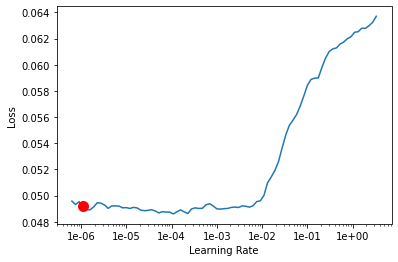

In [109]:
learn.recorder.plot(suggestion = True)

In [111]:
torch.save(learn.model, 'first_size')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AutoEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Encoder1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Encoder2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Encoder3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python

In [0]:
first_ae = torch.load('first_size')

In [122]:
first_ae.decoder[7]

Decoder1(
  (decoder): Sequential(
    (0): PixelShuffle_ICNR(
      (conv): Sequential(
        (0): Conv2d(64, 12, kernel_size=(1, 1), stride=(1, 1))
      )
      (shuf): PixelShuffle(upscale_factor=2)
      (pad): ReplicationPad2d((1, 0, 1, 0))
      (blur): AvgPool2d(kernel_size=2, stride=1, padding=0)
      (relu): ReLU(inplace=True)
    )
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
)

In [0]:
class AutoEncoder2(nn.Module):
    def __init__(self):
        super(AutoEncoder2, self).__init__()
        self.first_ae = torch.load('first_size')
        self.encoder = self.first_ae.encoder
        self.decoders = self.first_ae.decoder
        self.decoder = nn.Sequential(self.decoders[0],
                                     Decoder5(),
                                     self.decoders[4],
                                     self.decoders[5],
                                     self.decoders[6],
                                     self.decoders[7]
                                     )

    def encode(self, x): return self.encoder(x)

    def decode(self,x): return torch.clamp(self.decoder(x), min = 0, max=1)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return torch.clamp(decoded, min = 0, max = 1)

In [0]:
ae2 = AutoEncoder2()

# Learner

In [0]:
learn = Learner(get_data(32), ae2, loss_func = F.mse_loss)

In [126]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,0.077826,0.061077,00:14
1,0.062042,0.056297,00:14
2,0.056353,0.063677,00:14
3,0.052084,0.064559,00:14
4,0.047528,0.044999,00:14
5,0.043579,0.045170,00:14
6,0.040788,0.041236,00:14
7,0.038832,0.041783,00:14
8,0.037432,0.038380,00:14
9,0.036425,0.038435,00:14


In [132]:
learn.split(lambda m: (m.encoder[1], m.encoder[2], m.encoder[3], m.encoder[4], m.encoder[5], m.decoder[0], m.decoder[2], m.decoder[3], m.decoder[4]))
print("")

In [130]:
learn.summary()

AutoEncoder2
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 16, 16]         9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 16, 16]         128        True      
______________________________________________________________________
ReLU                 [64, 16, 16]         0          False     
______________________________________________________________________
MaxPool2d            [64, 8, 8]           0          False     
______________________________________________________________________
Conv2d               [64, 8, 8]           36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 8, 8]           128        True      
______________________________________________________________________
ReLU                 [64, 8, 8]           0          False     
_________________________________________________

In [28]:
tens.shape

torch.Size([32, 3, 32, 32])

In [29]:
tens2.shape

torch.Size([32, 3, 16, 16])

In [52]:
Encoder6().cuda()(Encoder5().cuda()(Encoder4().cuda()(Encoder3().cuda()(Encoder2().cuda()(Encoder1().cuda()(tens2.cuda())))))).shape

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


torch.Size([32, 1024, 1, 1])

In [37]:
Decoder6().cuda()(ae.encoder(tens2.cuda())).shape

torch.Size([32, 512, 1, 1])

In [50]:
Encoder5().cuda()(Encoder4().cuda()(Encoder3().cuda()(Encoder2().cuda()(Encoder1().cuda()(tens2.cuda()))))).shape

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


torch.Size([32, 512, 1, 1])

In [40]:
Decoder5().cuda()(Decoder6().cuda()(ae.encoder(tens2.cuda()))).shape

torch.Size([32, 256, 2, 2])

In [42]:
Decoder4().cuda()(Decoder5().cuda()(Decoder6().cuda()(ae.encoder(tens2.cuda())))).shape

torch.Size([32, 128, 4, 4])

In [49]:
Encoder4().cuda()(Encoder3().cuda()(Encoder2().cuda()(Encoder1().cuda()(tens2.cuda())))).shape

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


torch.Size([32, 256, 1, 1])

In [44]:
Decoder3().cuda()(Decoder4().cuda()(Decoder5().cuda()(Decoder6().cuda()(ae.encoder(tens2.cuda()))))).shape

torch.Size([32, 64, 8, 8])

In [48]:
Encoder3().cuda()(Encoder2().cuda()(Encoder1().cuda()(tens2.cuda()))).shape

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


torch.Size([32, 128, 2, 2])

In [45]:
Decoder2().cuda()(Decoder3().cuda()(Decoder4().cuda()(Decoder5().cuda()(Decoder6().cuda()(ae.encoder(tens2.cuda())))))).shape

torch.Size([32, 64, 16, 16])

In [47]:
Encoder2().cuda()(Encoder1().cuda()(tens2.cuda())).shape

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


torch.Size([32, 64, 4, 4])

In [46]:
Decoder1().cuda()(Decoder2().cuda()(Decoder3().cuda()(Decoder4().cuda()(Decoder5().cuda()(Decoder6().cuda()(ae.encoder(tens2.cuda()))))))).shape

torch.Size([32, 3, 32, 32])

In [43]:
Encoder1().cuda()(tens2.cuda()).shape

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


torch.Size([32, 64, 8, 8])

In [0]:
tens2 = torch.randn([32, 3, 16, 16])

In [55]:
test = Encoder1()(tens2)
test.shape

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


torch.Size([32, 64, 8, 8])

In [56]:
test = Decoder1()(test)
test.shape

torch.Size([32, 3, 16, 16])

In [0]:
tens2 = torch.randn([32, 64, 8, 8])

In [58]:
test = Encoder2()(tens2)
test.shape

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


torch.Size([32, 64, 4, 4])

In [59]:
test = Decoder2()(test)
test.shape

torch.Size([32, 64, 8, 8])

In [0]:
tens2 = torch.randn([32, 64, 4, 4])

In [61]:
test = Encoder3()(tens2)
test.shape

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


torch.Size([32, 128, 2, 2])

In [62]:
test = Decoder3()(test)
test.shape

torch.Size([32, 64, 4, 4])

In [0]:
tens2 = torch.randn([32, 128, 2, 2])

In [64]:
test = Encoder4()(tens2)
test.shape

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


torch.Size([32, 256, 1, 1])

In [65]:
test = Decoder4()(test)
test.shape

torch.Size([32, 128, 2, 2])

In [0]:
tens2 = torch.randn([32, 256, 1, 1])

In [74]:
test = Encoder5()(tens2)
test.shape

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


torch.Size([32, 512, 1, 1])

In [75]:
test = Decoder5()(test)
test.shape

torch.Size([32, 256, 1, 1])

In [0]:
tens2 = torch.randn([32, 512, 1, 1])

In [77]:
test = Encoder6()(tens2)
test.shape

torch.Size([32, 1024, 1, 1])

In [78]:
test = Decoder6()(test)
test.shape

torch.Size([32, 512, 1, 1])

In [79]:
ae = AutoEncoder()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [0]:
tens2 = torch.randn([32, 3, 16, 16])

In [83]:
test = ae.encode(tens2)
test.shape

torch.Size([32, 1024, 1, 1])

In [84]:
test = ae.decode(test)
test.shape

torch.Size([32, 3, 16, 16])

In [0]:
tens2 = torch.randn([32, 3, 32, 32])

In [86]:
test = ae.encode(tens2)
test.shape

torch.Size([32, 1024, 1, 1])

In [87]:
test = ae.decode(test)
test.shape

torch.Size([32, 3, 16, 16])

for resizing to work we need to upsample one less time than before. this means we have to save the weights from first model then add in new weights for the further upsample.

In [89]:
tens2 = torch.randn([32, 256, 1, 1])
nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)(tens2).shape

torch.Size([32, 512, 1, 1])

In [90]:
nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)(tens2).shape

torch.Size([32, 512, 1, 1])

In [91]:
tens2 = torch.randn([32, 256, 2, 2])
nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)(tens2).shape

torch.Size([32, 512, 2, 2])

In [92]:
nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)(tens2).shape

torch.Size([32, 512, 1, 1])

In [93]:
learn.summary()

AutoEncoder
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 8, 8]           9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 8, 8]           128        False     
______________________________________________________________________
ReLU                 [64, 8, 8]           0          False     
______________________________________________________________________
MaxPool2d            [64, 4, 4]           0          False     
______________________________________________________________________
Conv2d               [64, 4, 4]           36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 4, 4]           128        True      
______________________________________________________________________
ReLU                 [64, 4, 4]           0          False     
__________________________________________________